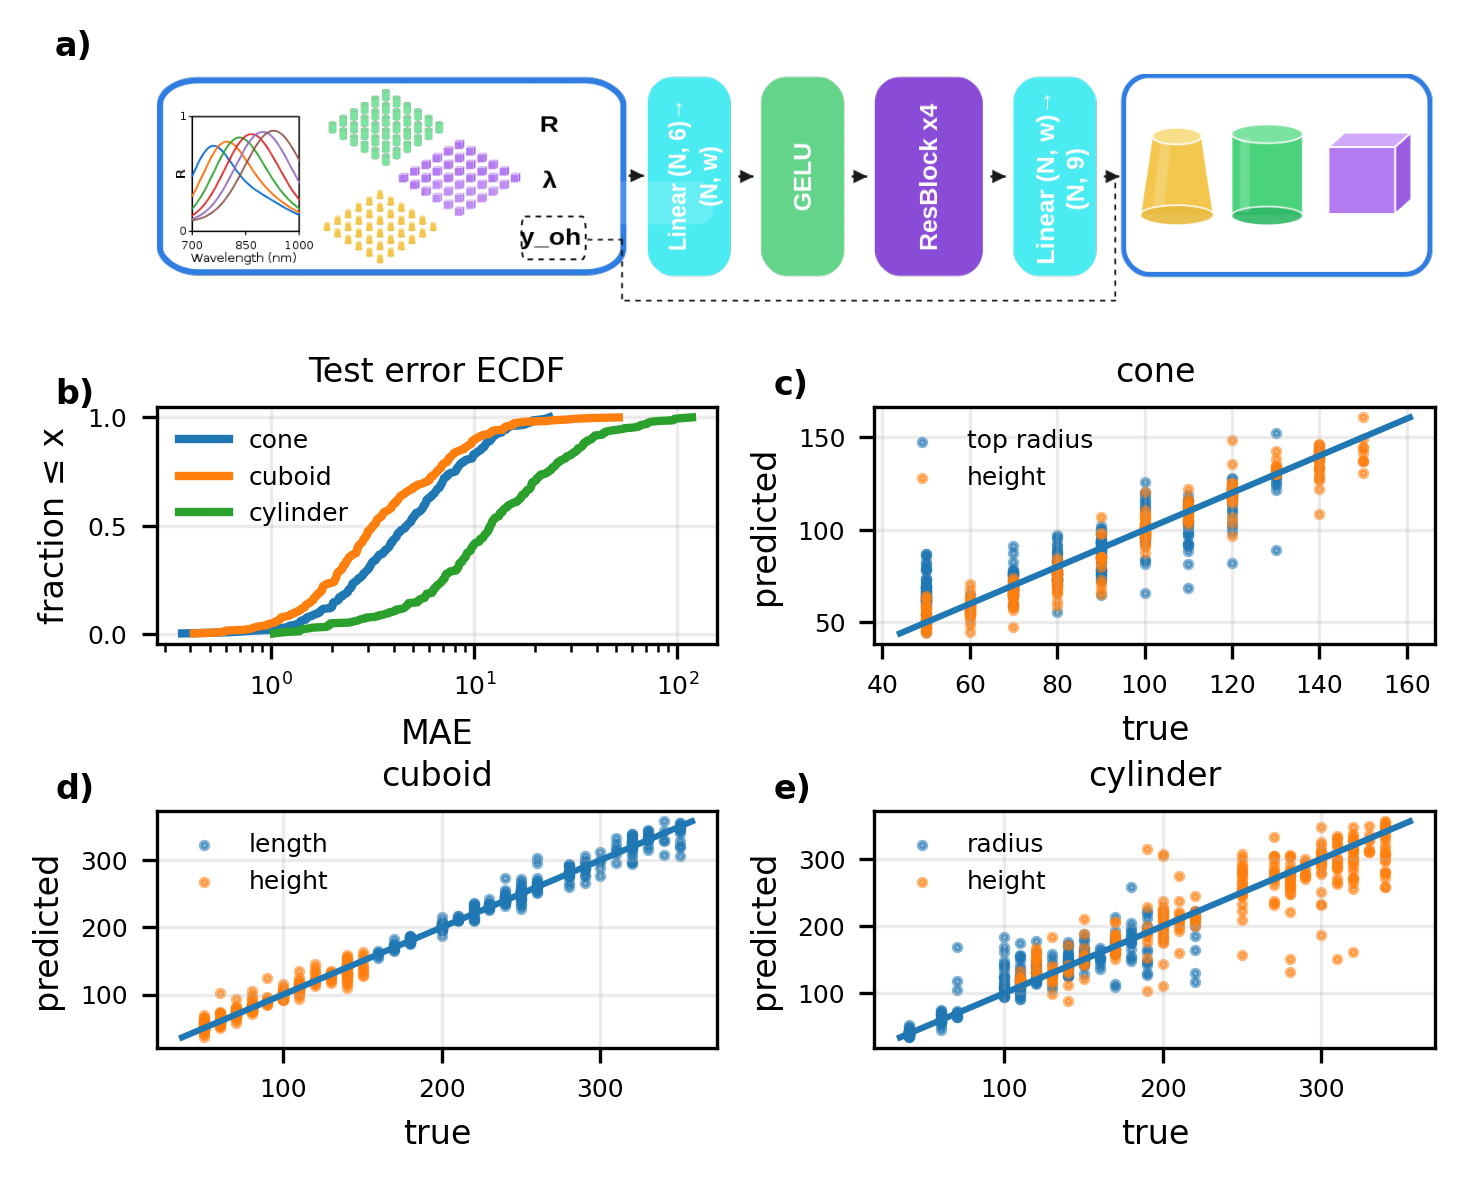

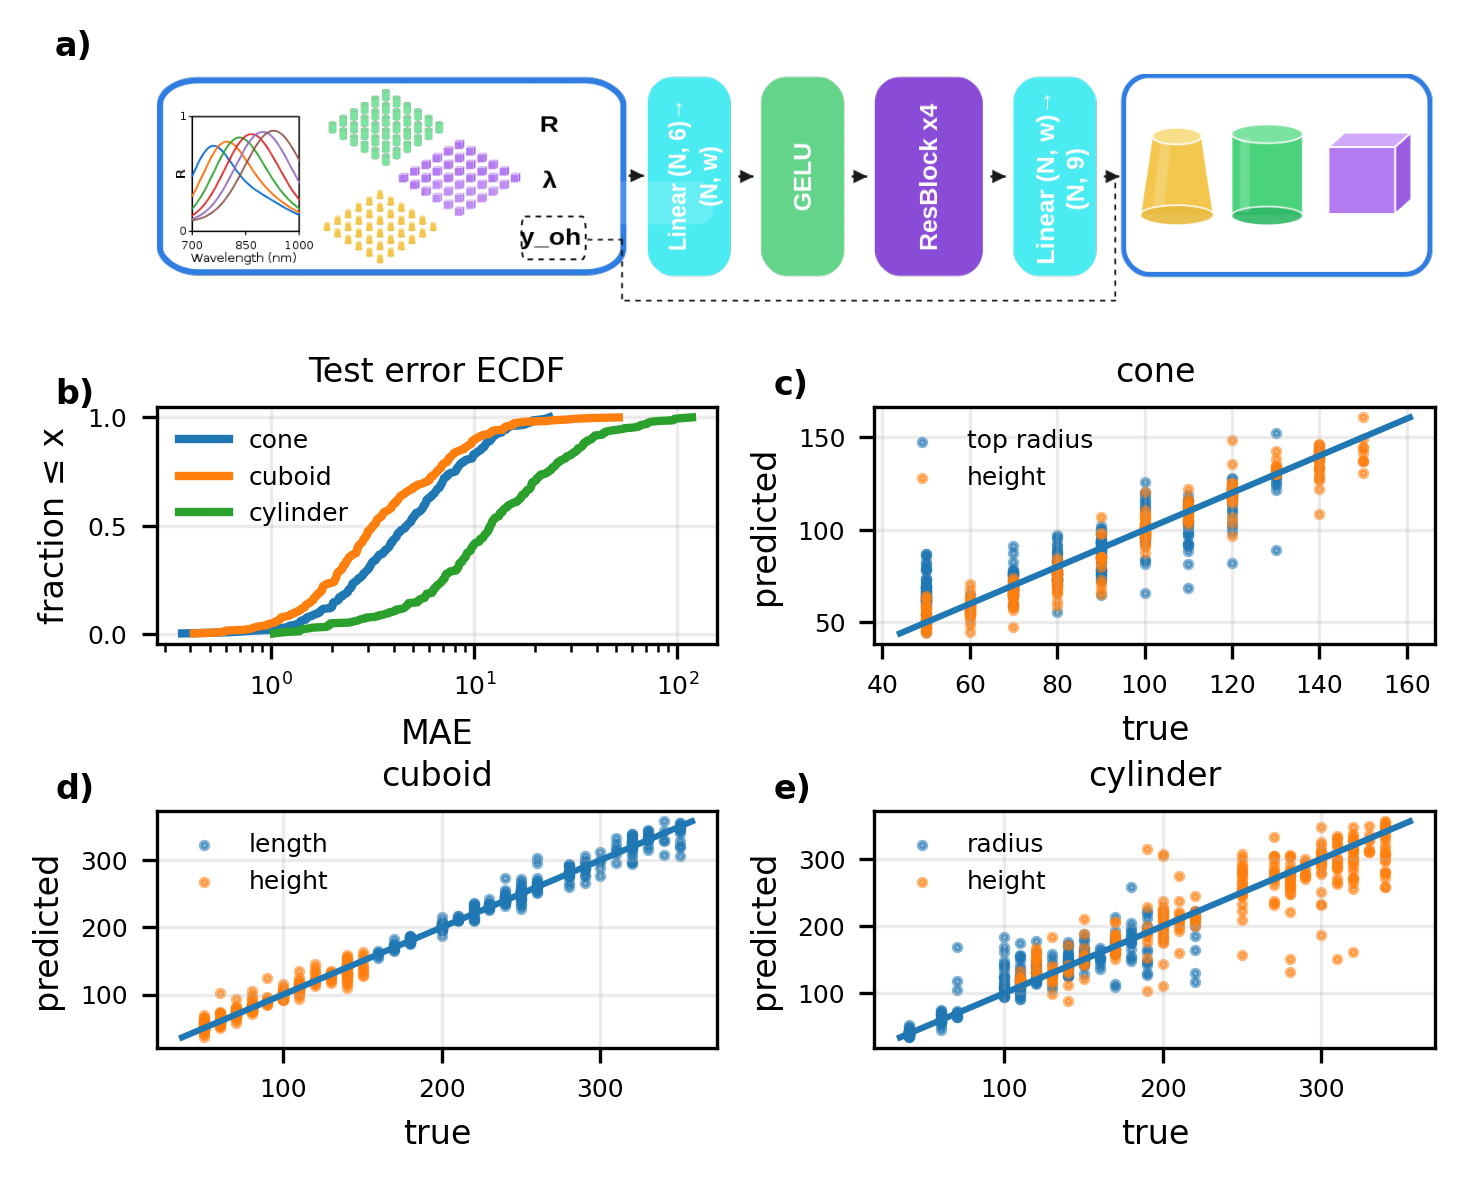

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker


def load_abcd_figdata_h5(path):
    """
    Load fig data saved by save_abcd_figdata_h5().
    Returns: theta_true, theta_pred, y_int, class_names, parity_spec, dims_by_class
    """
    def _to_str_list(arr):
        out = []
        for s in np.asarray(arr).ravel():
            if isinstance(s, (bytes, np.bytes_)):
                out.append(s.decode("utf-8"))
            else:
                out.append(str(s))
        return out

    with h5py.File(path, "r") as f:
        theta_true = f["theta_true"][...]
        theta_pred = f["theta_pred"][...]
        y_int      = f["y_int"][...]

        class_names = tuple(_to_str_list(f["class_names"][...]))

        parity_spec = {}
        gp = f["parity_spec"]
        for key in gp.keys():  # "class_0", ...
            c = int(key.split("_", 1)[1])
            dims = gp[key]["dims"][...].astype(int).tolist()
            names = _to_str_list(gp[key]["names"][...])
            parity_spec[c] = list(zip(dims, names))

        dims_by_class = {}
        gd = f["dims_by_class"]
        for key in gd.keys():  # "class_0", ...
            c = int(key.split("_", 1)[1])
            dims_by_class[c] = gd[key][...].astype(int).tolist()

    return theta_true, theta_pred, y_int, class_names, parity_spec, dims_by_class


def make_abcd_cdf_plus_parity(
    theta_true, theta_pred, y_int,
    *,
    class_names=("cone", "cuboid", "cylinder"),
    parity_spec=None,
    dims_by_class=None,
    logx=True,
    out_png=None,
    figsize=(5.5, 4.5),
    top_img=None,            
    top_row_height=1.2,
    top_img_aspect="equal",  # "equal" or "auto"
):
    theta_true = np.asarray(theta_true, float)
    theta_pred = np.asarray(theta_pred, float)
    y_int      = np.asarray(y_int, int).ravel()
    K = len(class_names)

    if parity_spec is None:
        parity_spec = {
            0: [(0, "p0"), (2, "p2")],
            1: [(0, "p0"), (2, "p2")],
            2: [(0, "p0"), (2, "p2")],
        }
    if dims_by_class is None:
        dims_by_class = {0: [0, 1, 2], 1: [0, 1, 2], 2: [0, 2]}

    # ---- error per sample for ECDF ----
    err = np.zeros_like(y_int, dtype=float)
    for c in np.unique(y_int):
        m = (y_int == c)
        dims = dims_by_class[int(c)]
        err[m] = np.mean(np.abs(theta_pred[m][:, dims] - theta_true[m][:, dims]), axis=1)

    fig = plt.figure(figsize=figsize)


    if top_img is not None:
        outer = GridSpec(
            3, 1, figure=fig,
            height_ratios=[top_row_height, 1.0, 1.0],
            hspace=0.1
        )
        ax_top = fig.add_subplot(outer[0, 0])
        ax_top.imshow(top_img, aspect=top_img_aspect)
        ax_top.set_xticks([]); ax_top.set_yticks([])
        for sp in ax_top.spines.values():
            sp.set_visible(False)
        ax_top.text(-0.08, 1.05, "a)", transform=ax_top.transAxes,
                    fontweight="bold", va="bottom", ha="left")

        gs = outer[1:].subgridspec(2, 2, wspace=0.28, hspace=0.7)
        letter_ecdf = "b"
        letter_pars = ["c", "d", "e"]
    else:
        gs = GridSpec(2, 2, figure=fig, wspace=0.28, hspace=0.32)
        letter_ecdf = "a"
        letter_pars = ["b", "c", "d"]

    # ---- ECDF panel ----
    ax_ecdf = fig.add_subplot(gs[0, 0])
    for c in range(K):
        m = (y_int == c)
        x = np.sort(err[m])
        if x.size == 0:
            continue
        y = np.arange(1, x.size + 1) / x.size
        ax_ecdf.plot(x, y, lw=2, label=f"{class_names[c]}")

    if logx:
        ax_ecdf.set_xscale("log")
        ax_ecdf.xaxis.set_major_locator(mticker.LogLocator(base=10.0, numticks=10))
        ax_ecdf.xaxis.set_major_formatter(mticker.LogFormatterMathtext(base=10.0))
        ax_ecdf.xaxis.set_minor_locator(mticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))
        ax_ecdf.xaxis.set_minor_formatter(mticker.NullFormatter())

    ax_ecdf.set_xlabel("MAE")
    ax_ecdf.set_ylabel("fraction ≤ x")
    ax_ecdf.set_title("Test error ECDF")
    ax_ecdf.grid(alpha=0.25)
    ax_ecdf.legend(frameon=False, loc="upper left")
    ax_ecdf.text(-0.18, 1.12, f"{letter_ecdf})", transform=ax_ecdf.transAxes,
                 fontweight="bold", va="top", ha="left")

    # ---- parity panels ----
    def parity_panel(ax, c, letter):
        spec = parity_spec[c]
        dims = [d for d, _ in spec]
        m = (y_int == c)
        yt = theta_true[m]
        yp = theta_pred[m]

        if yt.shape[0] == 0:
            ax.axis("off")
            return

        lo = float(np.min(np.r_[yt[:, dims].ravel(), yp[:, dims].ravel()]))
        hi = float(np.max(np.r_[yt[:, dims].ravel(), yp[:, dims].ravel()]))

        for d, name in spec:
            ax.scatter(yt[:, d], yp[:, d], s=3, alpha=0.55, label=name)

        ax.plot([lo, hi], [lo, hi], lw=1.5)
        ax.set_title(f"{class_names[c]}")
        ax.set_xlabel("true")
        ax.set_ylabel("predicted")
        ax.grid(alpha=0.25)
        ax.legend(frameon=False)
        ax.text(-0.18, 1.16, f"{letter})", transform=ax.transAxes,
                fontweight="bold", va="top", ha="left")

    ax_p0 = fig.add_subplot(gs[0, 1]); parity_panel(ax_p0, 0, letter_pars[0])
    ax_p1 = fig.add_subplot(gs[1, 0]); parity_panel(ax_p1, 1, letter_pars[1])
    ax_p2 = fig.add_subplot(gs[1, 1]); parity_panel(ax_p2, 2, letter_pars[2])

    if out_png:
        fig.savefig(out_png, dpi=600, bbox_inches="tight")

    plt.show()
    return fig


import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 300

fs = 8
mpl.rcParams.update({
    "font.size": fs,
    "axes.titlesize": fs,
    "axes.labelsize": fs,
    "xtick.labelsize": fs - 2,
    "ytick.labelsize": fs - 2,
    "legend.fontsize": fs - 2,
    "figure.titlesize": fs,
})

# %config InlineBackend.figure_format = 'retina' 

myfile = "results/rtoparam_results.h5"
theta_true, theta_pred, y_int, class_names, parity_spec, dims_by_class = load_abcd_figdata_h5(myfile)

top_img = plt.imread("figs/rtop.png")   

make_abcd_cdf_plus_parity(
    theta_true, theta_pred, y_int,
    class_names=class_names,
    parity_spec=parity_spec,
    dims_by_class=dims_by_class,
    logx=True,
    top_img=top_img,              
    out_png="figs/figure_7.png",
)
